# MACHINE LEARNING PROJECT: LUCA ZILLI, 983688
## Methods For Time Series Forecasting

In this jupyter notebook I show the code used for the time series prediction.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [638]:
# nicer figures
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 100
mpl.rcParams['axes.labelsize'] = 100
mpl.rcParams['legend.fontsize'] = 90
mpl.rcParams['xtick.labelsize'] = 90
mpl.rcParams['ytick.labelsize'] = 90
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

Downloading of the time series from a file excel.

In [ ]:
training_data_x = pd.read_excel("data.xlsx",usecols=[10,11,12,13,14])

In [643]:
#print(training_data_x)

In [641]:
volumes_time_series_uncompleted=training_data_x.to_numpy()
#print(volumes_time_series_uncompleted)

In [4]:
volumes_time_series=[]
for i in range(1,8665):
    for k in range(1,5):
        volumes_time_series.append(volumes_time_series_uncompleted[i][k])

In [642]:
nord_volumes=np.asarray(volumes_time_series[:int(4332*4)])
sud_volumes=np.asarray(volumes_time_series[int(4332*4):])
#print(nord_volumes)
#print(sud_volumes)

## What am I forecasting?

The energy's unbalances time series of the Italian power grid.

## Why this time series predictions are useful?

Electrical laws require that at each instant must be guaranteed the right balance between injections and withdrawals of the power grid.

In Italy Terna S.p.A. is responsible for this issue. It is a private company that maintains the equilibrium buying services from energy's productors in the "ancillary services market" (ASM).

The model for time series predictions needs to put Terna and the energy market’s operators under a minor risk when operating in the ASM.

Terna has collected old time series of energy’s unbalances every 15 minutes, and the values are labelled differently whether the energy consumed is in the northern or in the southern part of Italy. In this project I will use data of the north Italy dating back to the first months of 2019.

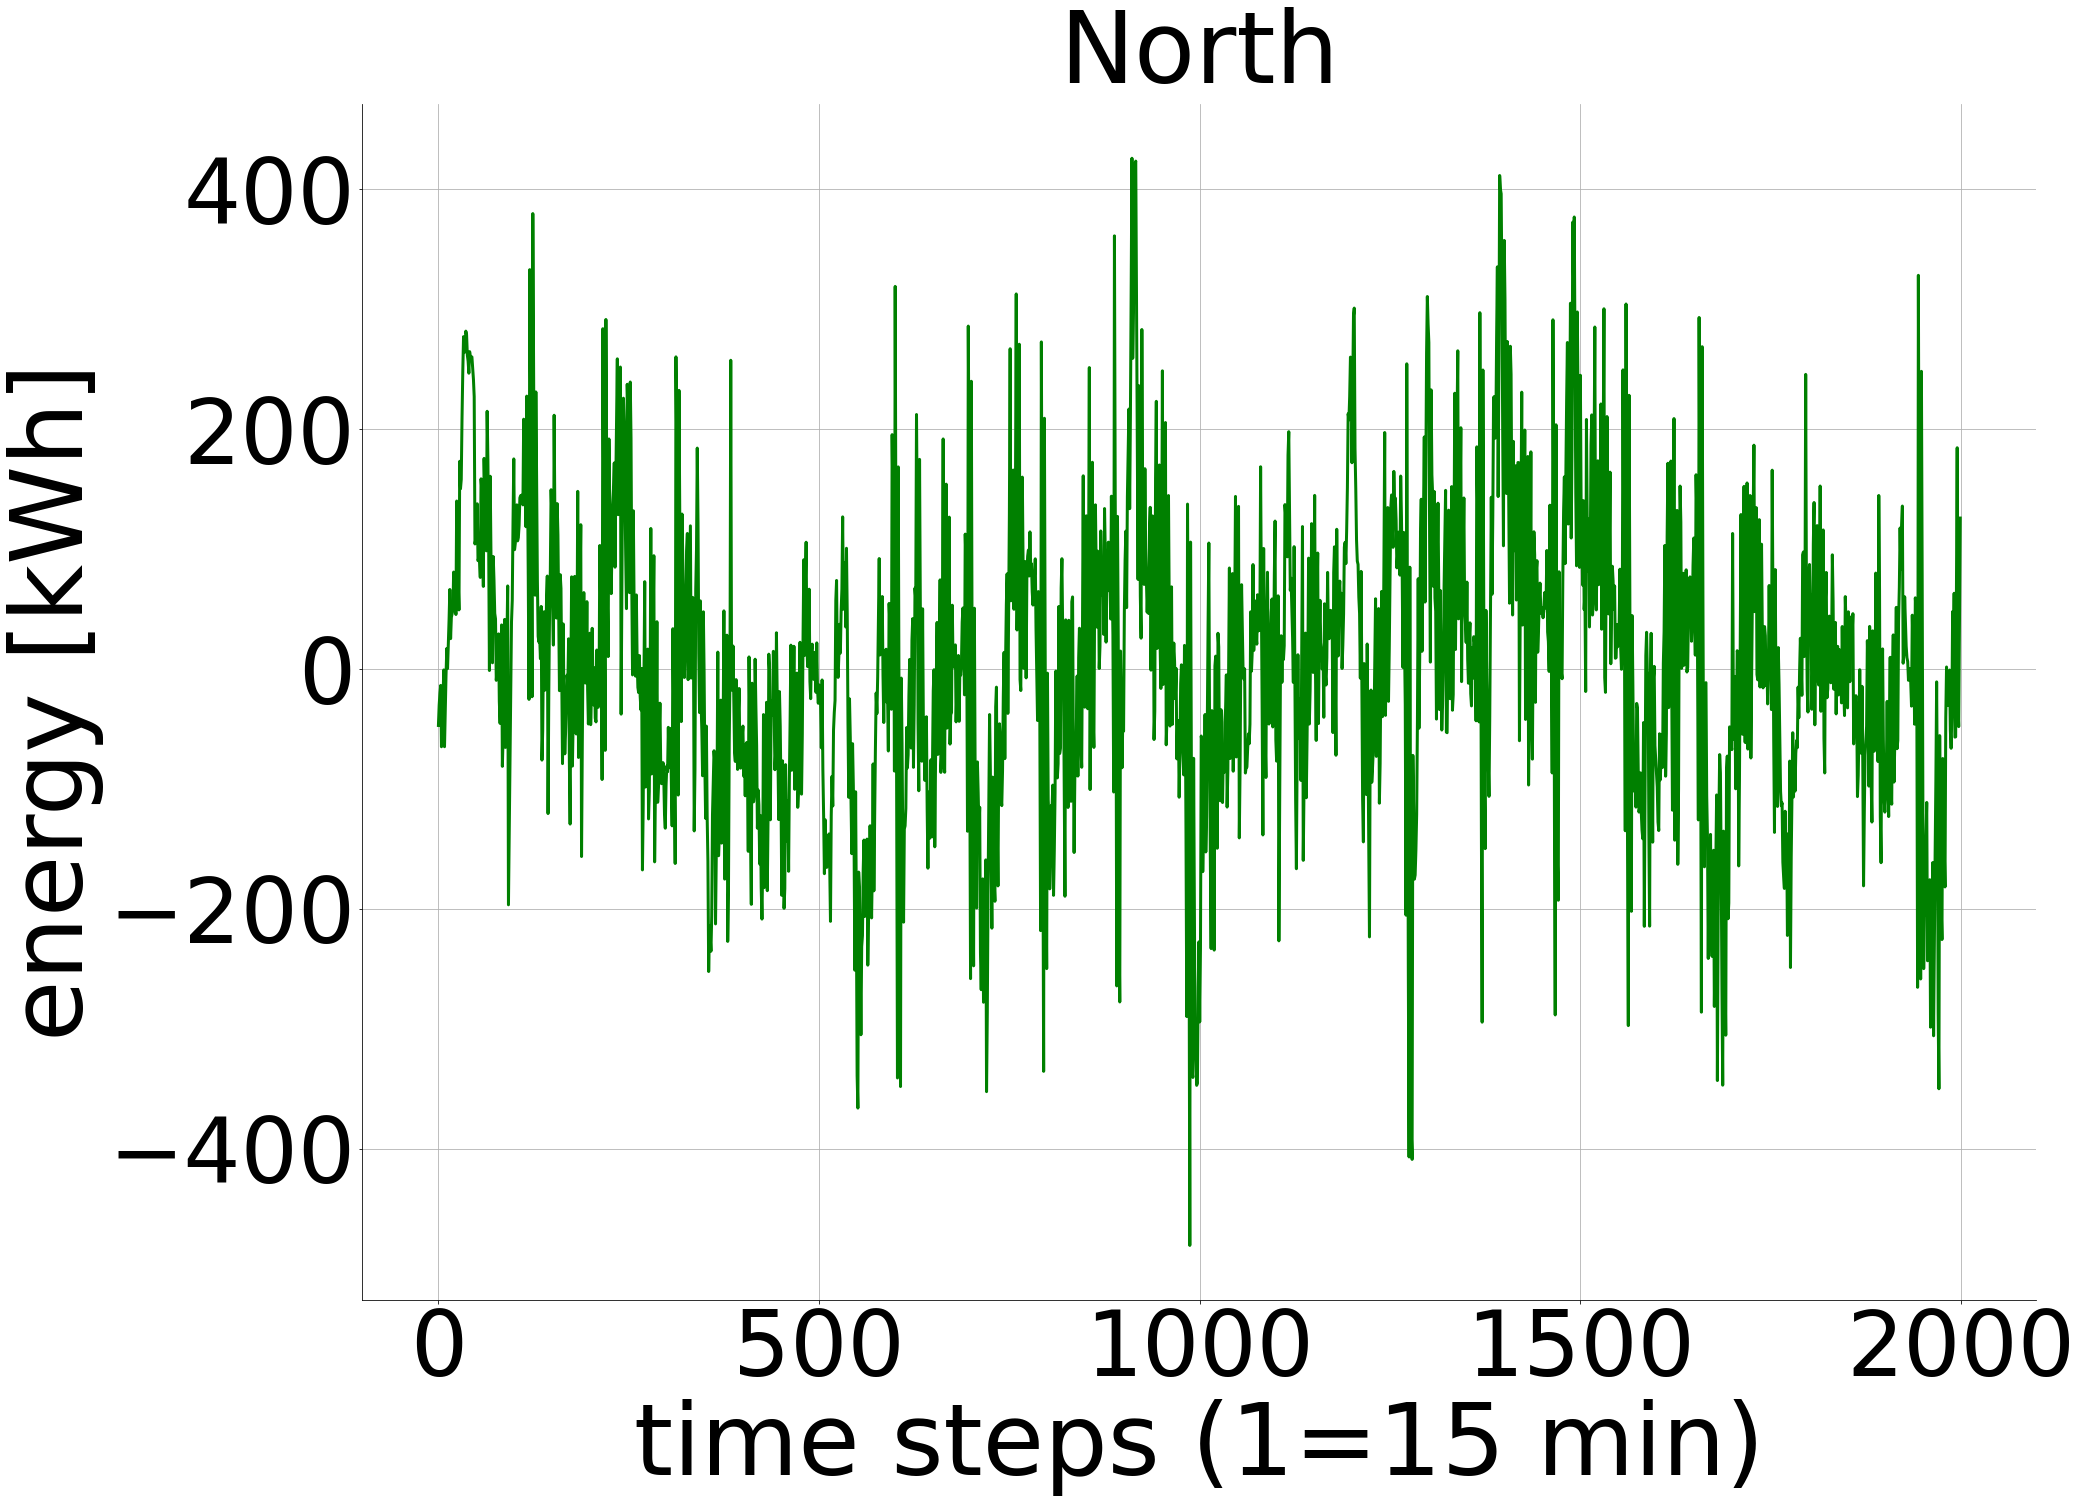

In [640]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))
volumes_time_series=np.asarray(volumes_time_series)
x=np.arange(volumes_time_series.size)
plt.plot(x[:2000], 
        nord_volumes[:2000], 
        color='g',
        lw=3,
        #marker='o',
        #markersize=10,
        #markerfacecolor="black" 
       )
plt.xlabel("time steps (1=15 min)")
plt.ylabel('energy [kWh]')
plt.title(f"North");

plt.grid(True)

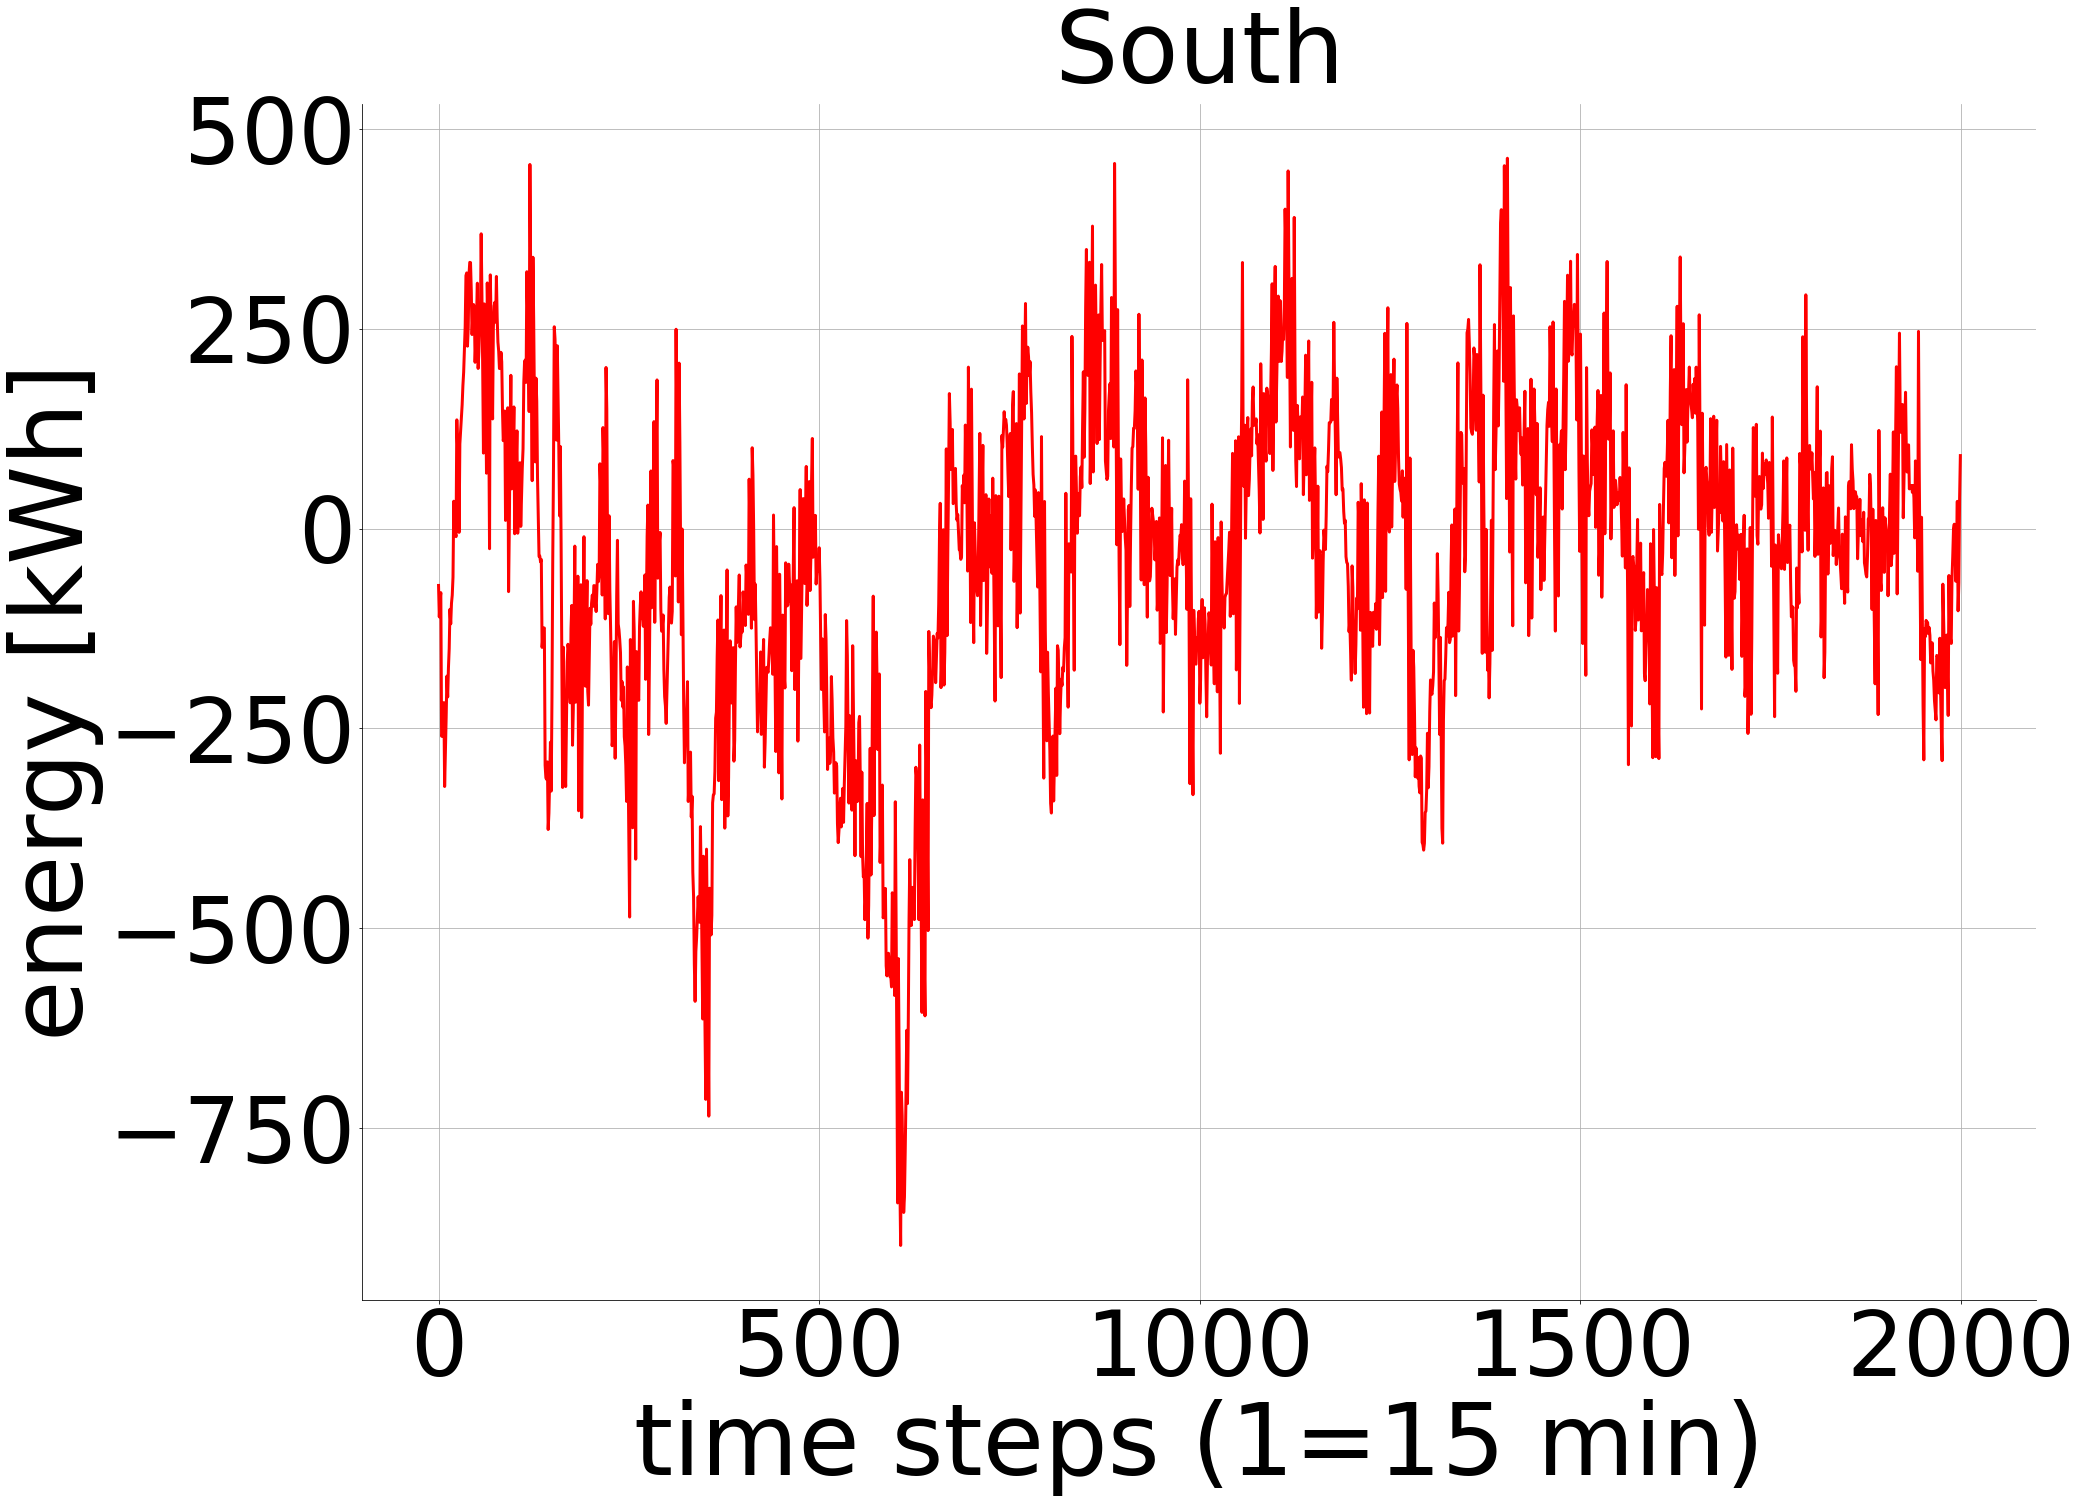

In [639]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))
volumes_time_series=np.asarray(volumes_time_series)
x=np.arange(volumes_time_series.size)
plt.plot(x[:2000], 
        sud_volumes[:2000], 
        color='r',
        lw=3,
        #marker='o',
        #markersize=10,
        #markerfacecolor="black" 
       )
plt.xlabel("time steps (1=15 min)")
plt.ylabel('energy [kWh]')
plt.title(f"South");

plt.grid(True)

## Machine Learning algorithms

In [18]:
# Start importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras import optimizers     
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical 


/Users/lucazilli/miniconda3/envs/calcolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lucazilli/miniconda3/envs/calcolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lucazilli/miniconda3/envs/calcolo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/lucazilli/miniconda3/

## Functions for data formatting

This is the function I used to format data for my thesis work. It transform the dataset 
$D=(y_1,y_2,...y_T)$ in the tensor called *$D_1$* in the report. 

S fix the length of the sequence in each batch, while $T_P$ is the prediction time interval.

In [646]:
# FORMAT_DATA D1
def create_batches(df, S, input, output, Tp,size):
    ## Create X         
        x_data = df[:size-Tp] # Select the data
        print(f'x_data {x_data.size}')
        X_batches = x_data.reshape(-1, S, input)  # Reshape the data 
    ## Create y
        y_data = df[Tp:size]
        print(f'y_data {y_data.size}')
        y_batches = y_data.reshape(-1, S, output)
        return X_batches, y_batches

This is the second function to format data. It transform the dataset 
$D=(y_1,y_2,...y_T)$ in the tensor called *$D_2$* in the report. I found it in the repository of the course "Machine Learning con applicazioni" and it permits the network to forecast with better accuracy for large prediction time-interval.

It takes only the parameter S which, in this format, correspond to $T_P$ .

In [647]:
# FORMAT_DATA D2
def format_data(data, S = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-S):
        # Get the next length_of_sequence elements
        a = data[i:i+S]
        # Get the element that immediately follows that
        b = data[i+S]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output



## In these cells I defined functions for my models' initialization

Since I will forecast a 1-dimensional time series, all my models will present both an input layer and an output layer of size 1. The hidden layer will be made by different type of RNN cells. 

The first model that I present is a simple RNN cell with a hidden state of arbitrary size, 1 neuron in the input layer and 1 neuron in the output layer.    

In [654]:
def rnn(S, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    length_of_sequences=S
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 32
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    hidden_dense=(Dense(8, activation="relu"))(rnn)
    dens = Dense(in_out_neurons,name="dense")(hidden_dense)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

For my thesis I used an hidden size equal to 1000 to maximize the predictive power. 

In [655]:
def rnn_old(S, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    length_of_sequences=S
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 1000
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    #hidden_dense=(Dense(8, activation="relu"))(rnn)
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

The second model presented is a LSTM cell with hidden size equal to 32, 1 neuron in the input layer and 1 neuron in the output layer.

In [656]:
def my_lstm(S, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    length_of_sequences=S
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 32
    #hidden_neurons = 1000
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    
    #dens1 = Dense(hidden_neurons,name="dens1")(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

The third model presented is a deeper LSTM made of 2 hidden layer:
1. the first with size equal to 32.
2. the second of size equal to 1.

As always 1 neuron in the input layer and 1 neuron in the output layer.

In [657]:
def lstm_2layers(S, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    length_of_sequences=S
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 32
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN", use_bias=False, activation='tanh')(inp)
    rnn1 = LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN1", use_bias=True, activation='tanh')(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn1)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model



## Create a model using the second data format $D_2$

In [659]:
Tp = 30
N = 1000     
X_tot=np.arange(0,N)
y_tot=nord_volumes[:N]
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=700

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of step
rnn_input, rnn_training = format_data(y_train, Tp)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use 
#model = lstm_2layers(S = Tp)
model = rnn(S = Tp)
#model = my_lstm(S = Tp)
model.summary()


# Fit the model using the training data genenerated above using 80 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=80, 
                 verbose=True,
                 validation_split=0.05)


Model: "model_343"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_347 (InputLayer)       [(None, 30, 1)]           0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 32)                1088      
_________________________________________________________________
dense_56 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________
Train on 636 samples, validate on 34 samples
Epoch 1/80
636/636 [==============================] - 60s 94ms/sample - loss: 14250.9246 - val_loss: 8483.8744
Epoch 2/80
636/636 [==============================] - 1s 815us/sample - loss: 14125.6919 - val_lo

636/636 [==============================] - 0s 782us/sample - loss: 4807.7748 - val_loss: 5848.0676
Epoch 67/80
636/636 [==============================] - 1s 835us/sample - loss: 4743.5673 - val_loss: 6012.6330
Epoch 68/80
636/636 [==============================] - 1s 1ms/sample - loss: 4633.6380 - val_loss: 5614.3129
Epoch 69/80
636/636 [==============================] - 0s 615us/sample - loss: 4568.8101 - val_loss: 5495.5163
Epoch 70/80
636/636 [==============================] - 1s 2ms/sample - loss: 4543.0314 - val_loss: 5727.0410
Epoch 71/80
636/636 [==============================] - 1s 808us/sample - loss: 4437.3017 - val_loss: 5725.0746
Epoch 72/80
636/636 [==============================] - 1s 841us/sample - loss: 4517.6769 - val_loss: 5919.2331
Epoch 73/80
636/636 [==============================] - 1s 994us/sample - loss: 4479.3847 - val_loss: 5621.3540
Epoch 74/80
636/636 [==============================] - 1s 906us/sample - loss: 4490.5173 - val_loss: 5611.6440
Epoch 75/80
636/6

In [662]:
test = y_tot[dim:]
testX,testY   = format_data(test,Tp)


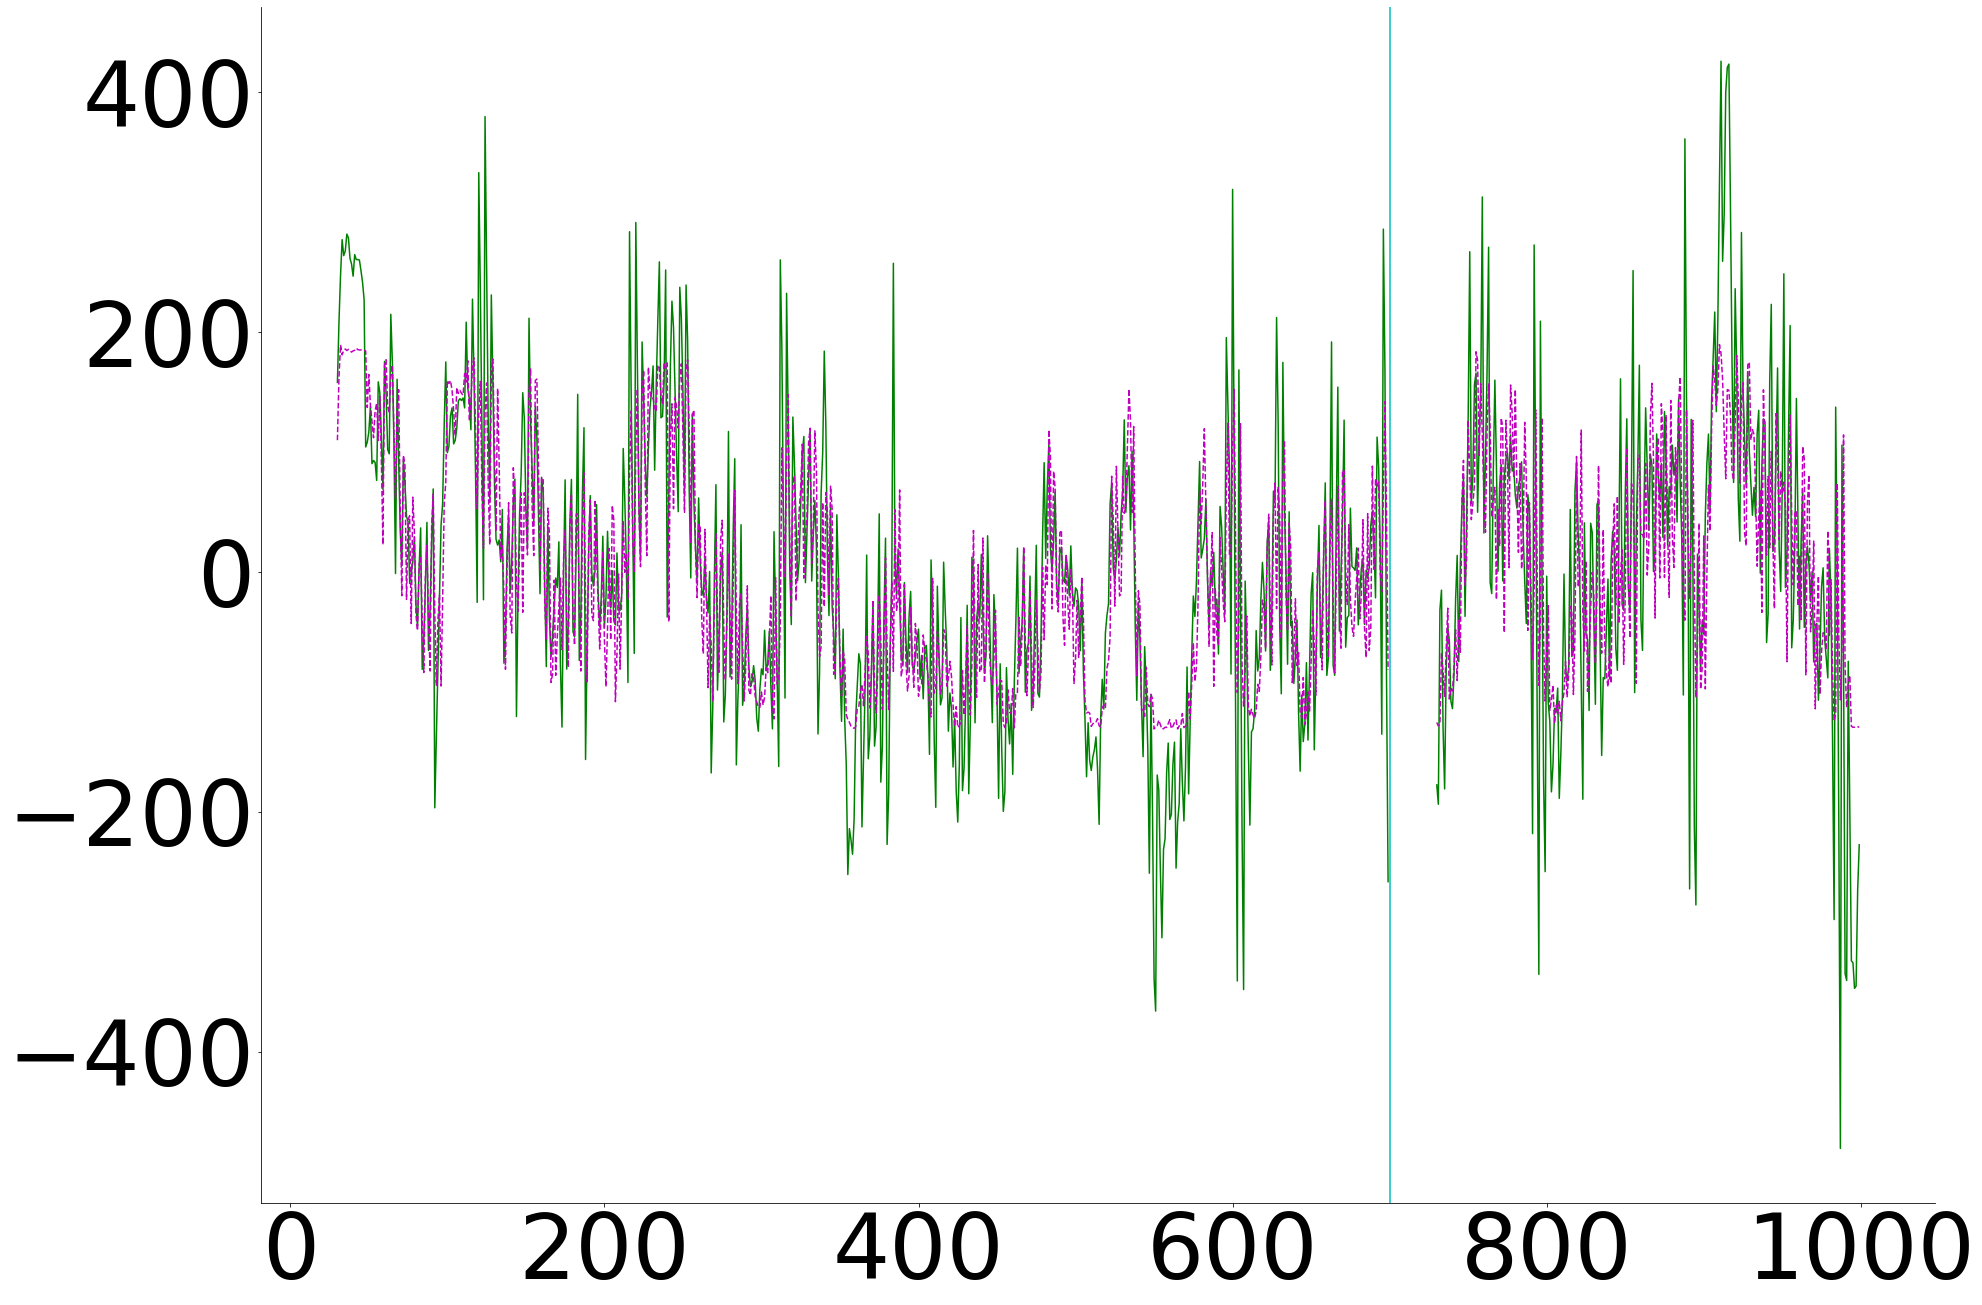

In [669]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))
trainPredict = model.predict(rnn_input)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)


plt.plot(np.arange(Tp,dim),y_tot[Tp:dim],'g')
plt.plot(np.arange(Tp,dim),trainPredict,'m--')

plt.plot(np.arange(dim+Tp,N),y_tot[dim+Tp:],'g')
plt.plot(np.arange(dim+Tp,N),testPredict,'m--')
plt.axvline(df.index[dim], c="c")
plt.show()

Measure the correlation coeffcient between your actutual and predicted time series for $T_P$ time step.

In [670]:
print(f"correlation coefficient:\n\n {np.corrcoef([y_tot[dim+Tp:],np.ravel(testPredict)])}")

correlation coefficient:

 [[1.        0.6820206]
 [0.6820206 1.       ]]


## Creating graph $\rho(T_P)$

Use this loop "for" to create graph $\rho(T_P)$ using *$D_2$* data format.

In [672]:

#rho_RNN_basic = np.zeros(30)
#rho_RNN_LSTM_new = np.zeros(20)
#rho_RNN_deep_LSTM_new = np.zeros(20)

cont=0

N = 1000     
X_tot=np.arange(0,N)
y_tot=nord_volumes[:N]
for Tp in range(1,21):
    
    
    # Check to make sure the data set is complete
    assert len(X_tot) == len(y_tot)

    # This is the number of points that will be used in as the training data
    dim=700

    # Separate the training data from the whole data set
    X_train = X_tot[:dim]
    y_train = y_tot[:dim]


    # Generate the training data for the RNN, using a sequence of 2
    rnn_input, rnn_training = format_data(y_train, Tp)


    # Create a recurrent neural network in Keras and produce a summary of the 
    # machine learning model
    # Change the method name to reflect which network you want to use 
    model = lstm_2layers(S = Tp)
    #model = rnn(S = Tp)
    #model = my_lstm(S = Tp)
    #model.summary()
    
    
    # Fit the model using the training data genenerated above using 150 training iterations and a 5%
    # validation split.  Setting verbose to True prints information about each training iteration.
    hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=80, 
                 verbose=False,
                 validation_split=0.05)
    
    
    
    test = y_tot[dim:]
    testX,testY= format_data(test,Tp)
    testPredict= model.predict(testX)
                                      
   
    #correlation coefficient
    rho_Matrix=np.corrcoef([y_tot[dim+Tp:],np.ravel(testPredict)])
    #rho_RNN_deep_LSTM_new[cont]=rho_Matrix[0][1]
    print(f'step {Tp}')
    print(rho_Matrix[0][1])
    cont=cont+1

    



step 1
0.6100035047965165


KeyboardInterrupt: 

### Comparison of the accuracy of models created by different RNNs using data fromat $D_2$

(0.0, 1.0)

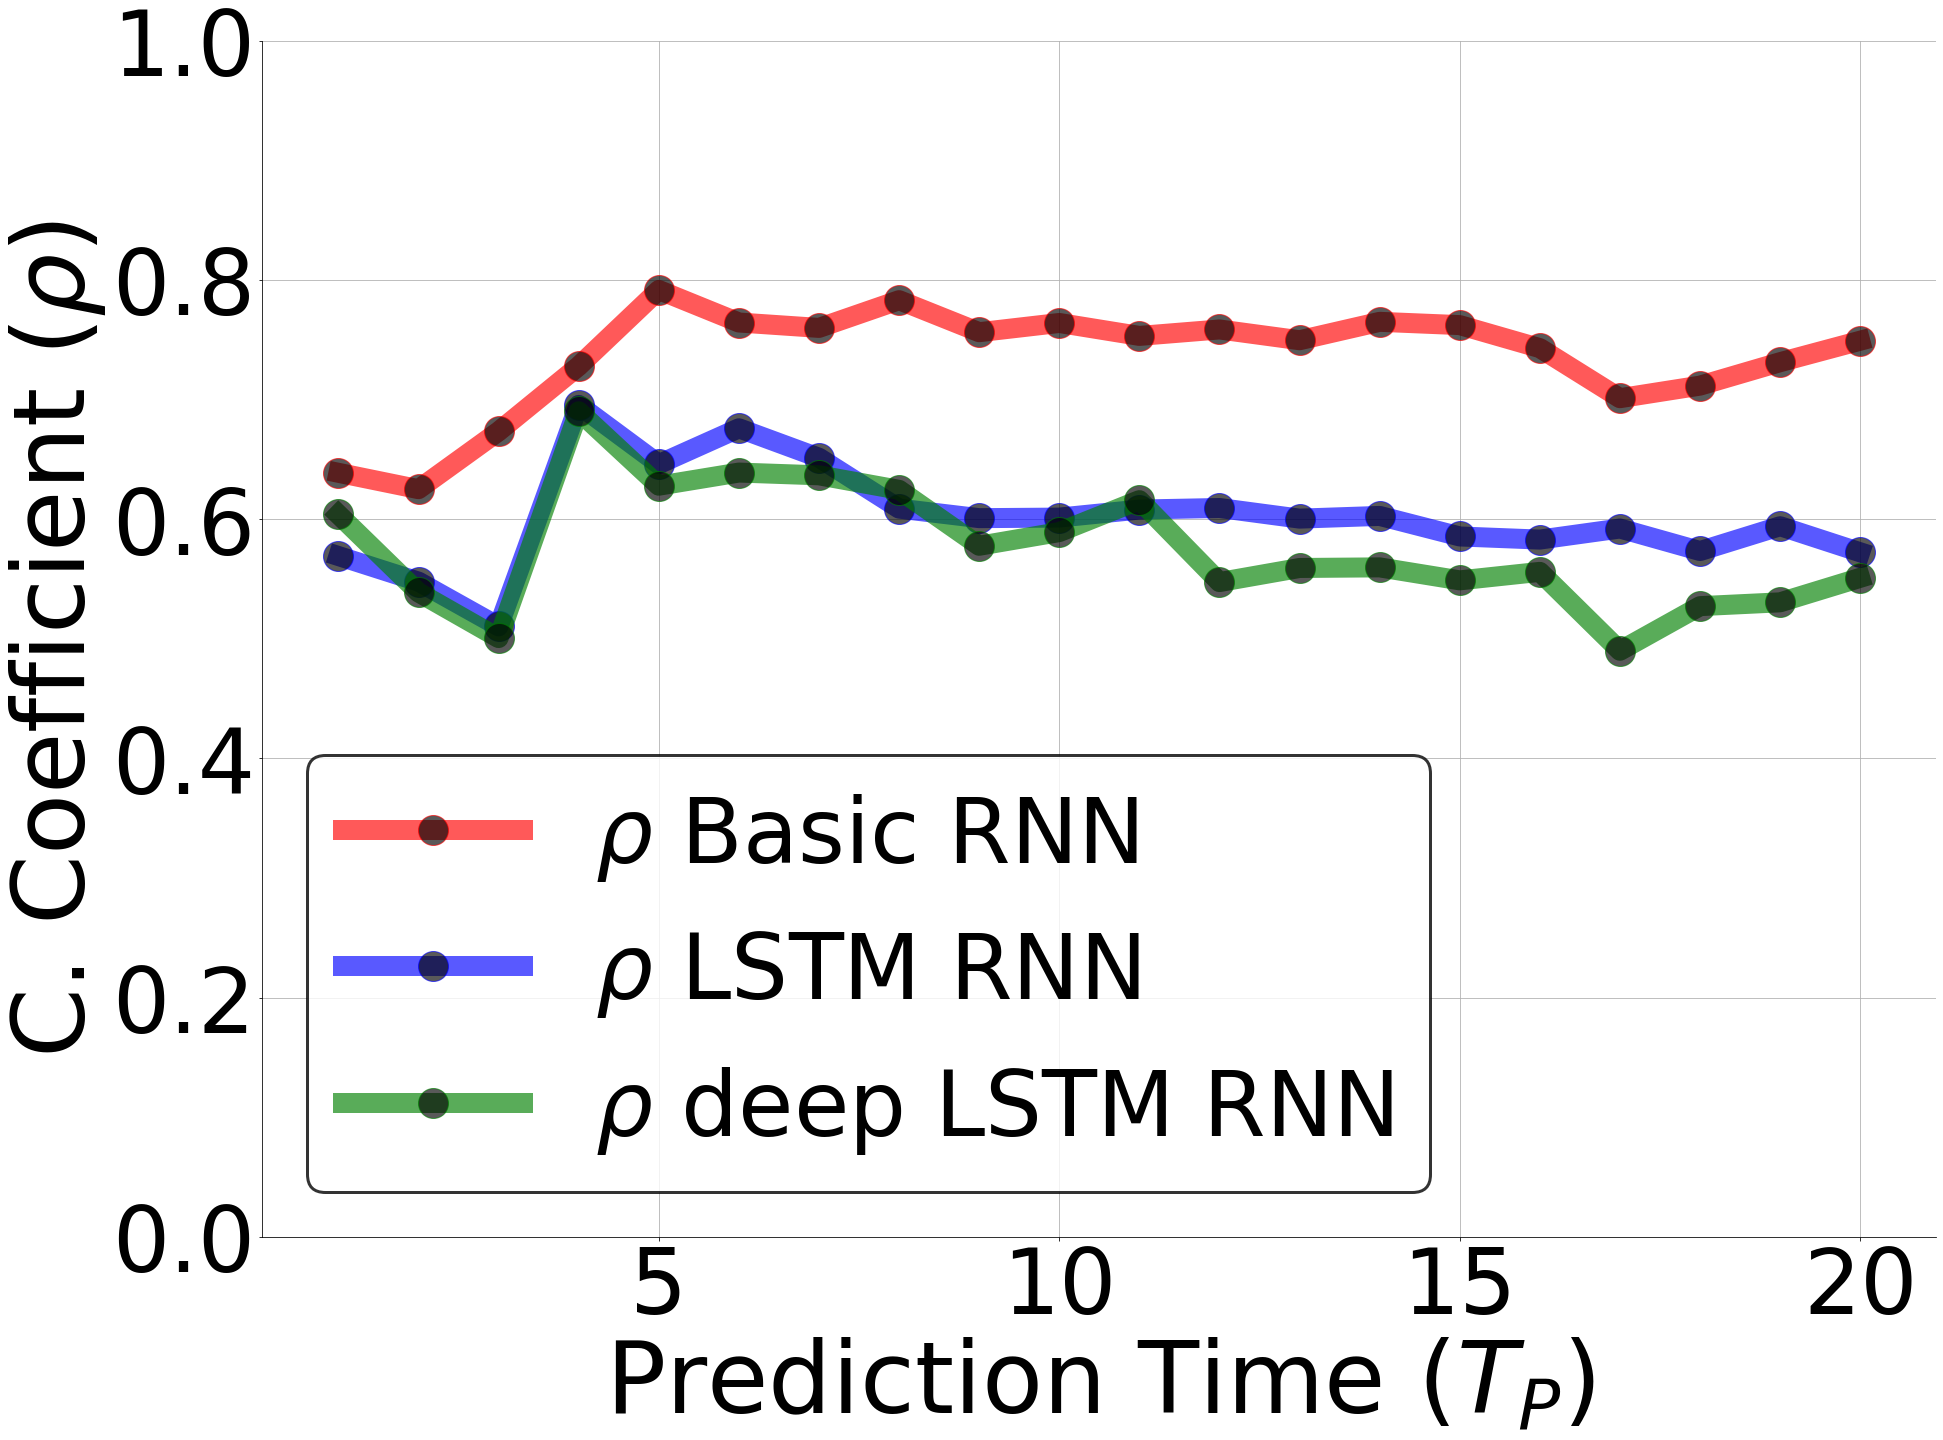

In [636]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))

    
step_vect = np.arange(1,21)

ax.plot(step_vect, 
        rho_RNN_basic[:20],
        color="red",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic RNN',
        
       )

ax.plot(step_vect, 
        rho_RNN_LSTM_new[:20],
        color="blue",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ LSTM RNN',
        
       )



ax.plot(step_vect,
        rho_RNN_deep_LSTM_new,
        color="green",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ deep LSTM RNN')


plt.grid(True)
# add labels for axes
ax.set_xlabel("Prediction Time ("+r"$T_P$"+")")
plt.ylabel('C. Coefficient ('+'$\\rho$'+')')

# add legend
leg = ax.legend(loc="lower left",frameon=True,prop={'size': 90})
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(3)

#ax.set_title(f'North Italy');
plt.ylim(bottom=0,top=1)

(0.0, 1.0)

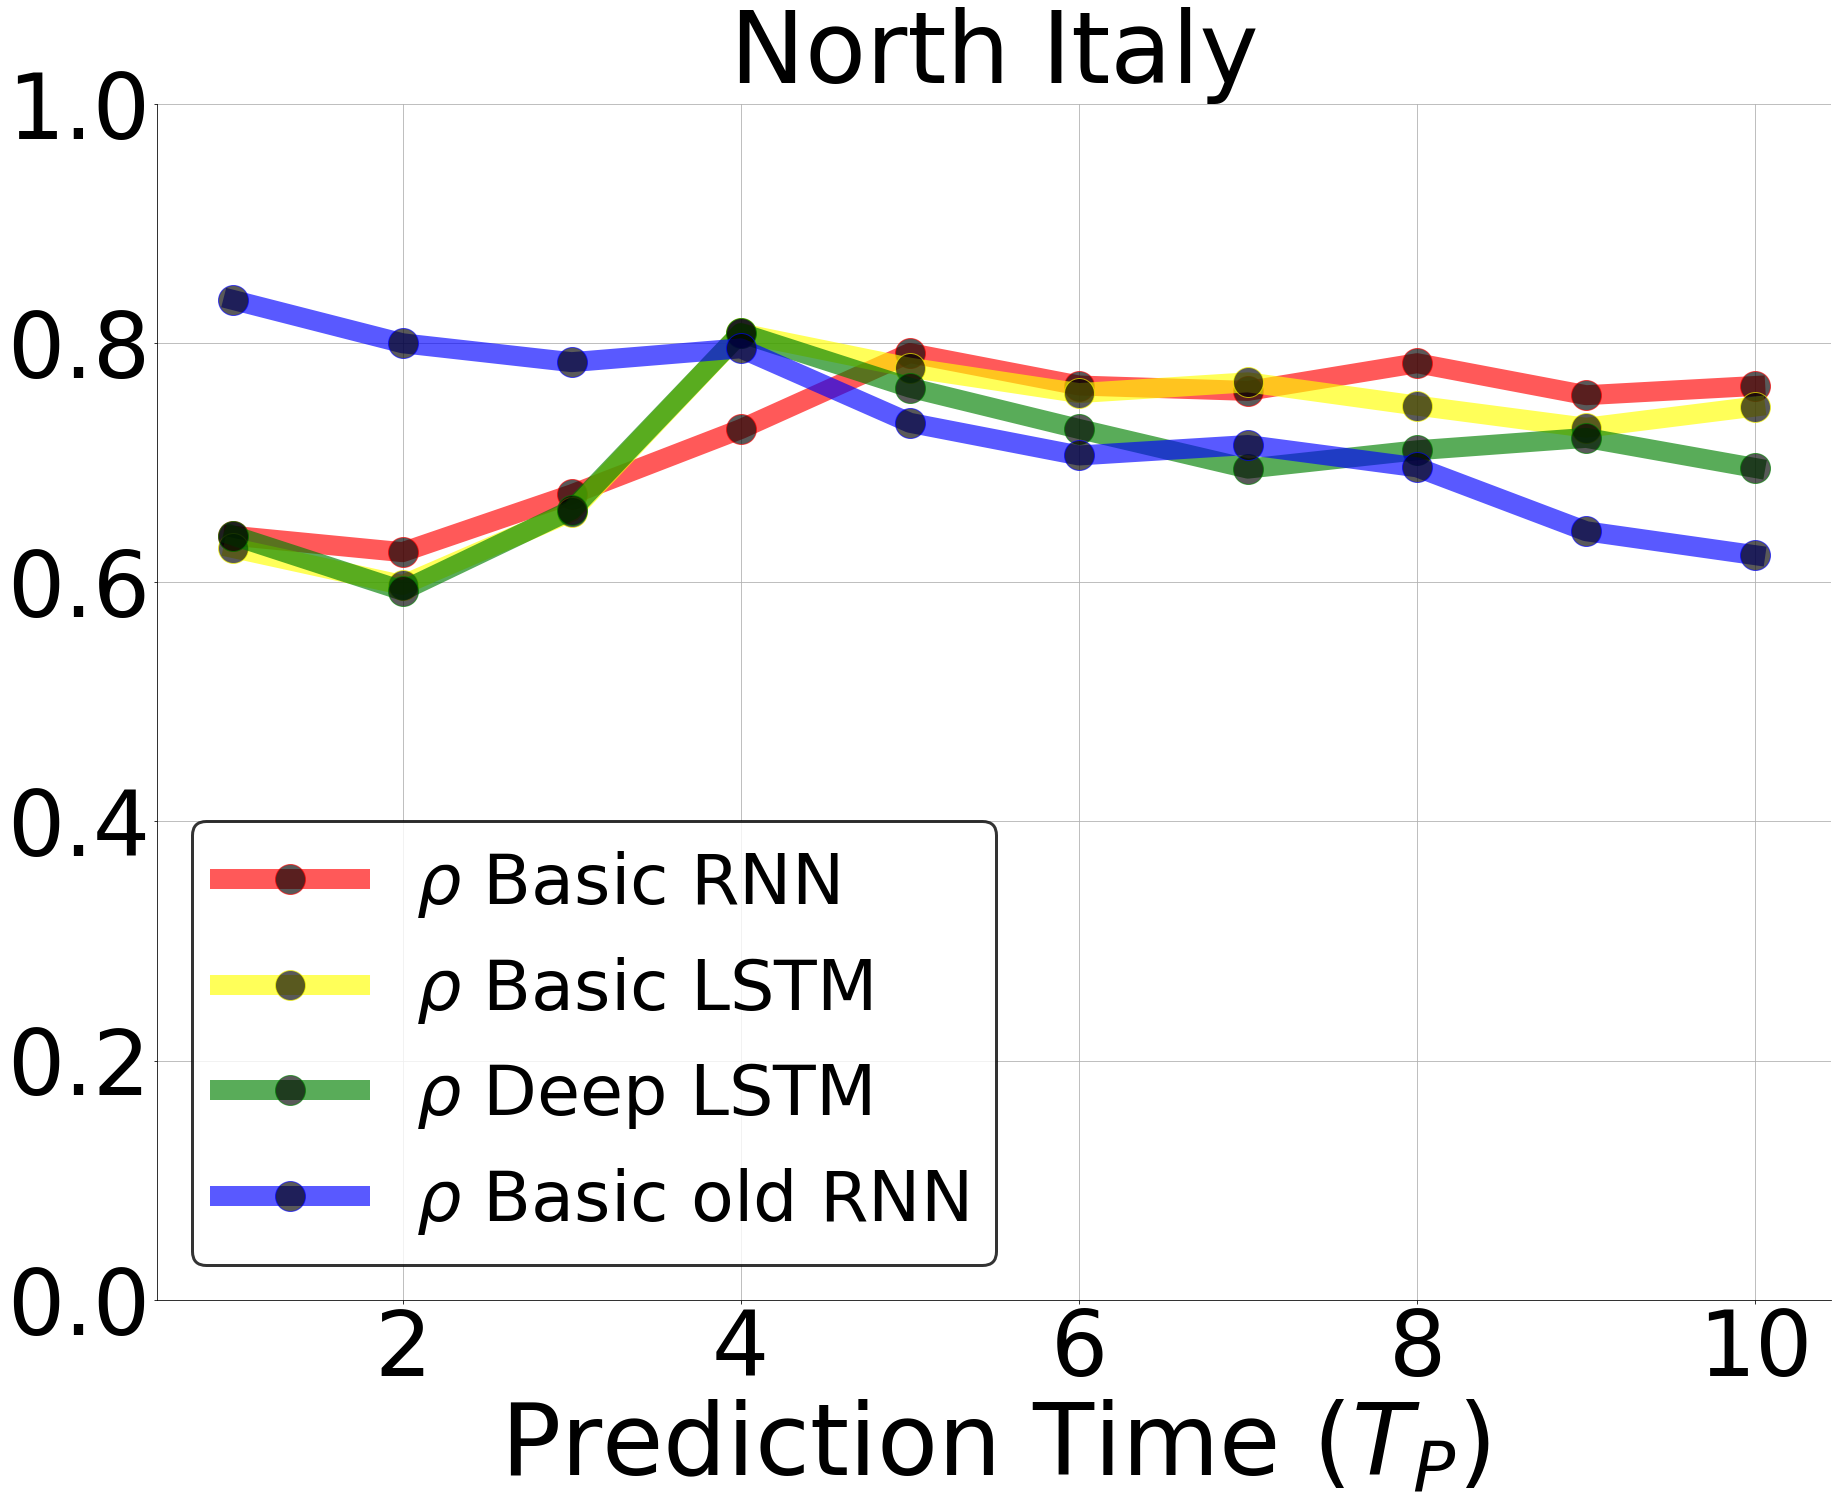

In [553]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))

    
step_vect = np.arange(1,31)

ax.plot(step_vect[0:10], 
        rho_RNN_basic[0:10],
        color="red",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic RNN',
        
       )



ax.plot(step_vect[0:10],
        rho_RNN_LSTM_basic[0:10],
        color="yellow",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic LSTM')

ax.plot(step_vect[0:10],
        rho_RNN_LSTM_deep[0:10],
        color="green",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Deep LSTM')

ax.plot(step_vect[0:10], 
        rho_RNN_old_step[0:10],
        color="blue",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic old RNN',
        
       )


plt.grid(True)
# add labels for axes
ax.set_xlabel("Prediction Time ("+r"$T_P$"+")")
#plt.ylabel('C. Coefficient ('+'$\\rho$'+')')

# add legend
leg = ax.legend(loc="lower left",frameon=True,prop={'size': 70})
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(3)

ax.set_title(f'North Italy');
plt.ylim(bottom=0,top=1)

## Create a model using the first data format $D_1$

### Remember 
change in the model initializing function the parameter return sequence=True to match the model with the new data format.

In [674]:
#hyperparameters
step_futuro=10
n_windows = 100   
n_input =  1
n_output = 1
size_train = 10000+step_futuro
size_test=3000+step_futuro
print(f'size_train {size_train}')
    
#dataset
train_set = nord_volumes[:size_train]
test_set = nord_volumes[size_train:size_test+size_train]
    
X_batches, y_batches = create_batches(df = train_set,
                                      S = n_windows,
                                      input = n_input,
                                      output = n_output,
                                      Tp=step_futuro,
                                      size=size_train)
    
X_test, y_test = create_batches(df = test_set,
                                S = n_windows,
                                input = n_input,
                                output = n_output,
                                Tp=step_futuro,
                                size=size_test)

size_train 10010
x_data 10000
y_data 10000
x_data 3000
y_data 3000


In [677]:
# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=700

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, S=step_futuro)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use 
#model = lstm_2layers(S = n_windows)
model = rnn_old(S = n_windows)
#model = my_lstm(S = n_windows)
model.summary()


# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(X_batches, y_batches, batch_size=None, epochs=80, 
                 verbose=True,
                 validation_split=0.05)



Model: "model_348"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_352 (InputLayer)       [(None, 100, 1)]          0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 100, 1000)         1002000   
_________________________________________________________________
dense (Dense)                (None, 100, 1)            1001      
Total params: 1,003,001
Trainable params: 1,003,001
Non-trainable params: 0
_________________________________________________________________
Train on 95 samples, validate on 5 samples
Epoch 1/80
95/95 [==============================] - 61s 639ms/sample - loss: 16721.4363 - val_loss: 17559.2129
Epoch 2/80
95/95 [==============================] - 2s 23ms/sample - loss: 15990.4483 - val_loss: 17121.3379
Epoch 3/80
95/95 [==============================] - 2s 20ms/sample - loss: 15557.0621 - val_loss: 16851.7539
Epoch

95/95 [==============================] - 2s 26ms/sample - loss: 11813.5429 - val_loss: 13237.6094
Epoch 69/80
95/95 [==============================] - 2s 25ms/sample - loss: 11620.3919 - val_loss: 13308.4092
Epoch 70/80
95/95 [==============================] - 2s 24ms/sample - loss: 11433.3038 - val_loss: 13496.4150
Epoch 71/80
95/95 [==============================] - 2s 24ms/sample - loss: 11239.5065 - val_loss: 13323.9189
Epoch 72/80
95/95 [==============================] - 3s 29ms/sample - loss: 11082.3741 - val_loss: 13316.5752
Epoch 73/80
95/95 [==============================] - 2s 26ms/sample - loss: 11022.0139 - val_loss: 13117.1719
Epoch 74/80
95/95 [==============================] - 3s 27ms/sample - loss: 10898.3796 - val_loss: 12984.0918
Epoch 75/80
95/95 [==============================] - 3s 27ms/sample - loss: 10838.8519 - val_loss: 13230.2275
Epoch 76/80
95/95 [==============================] - 3s 27ms/sample - loss: 10766.2578 - val_loss: 13189.5342
Epoch 77/80
95/95 [===

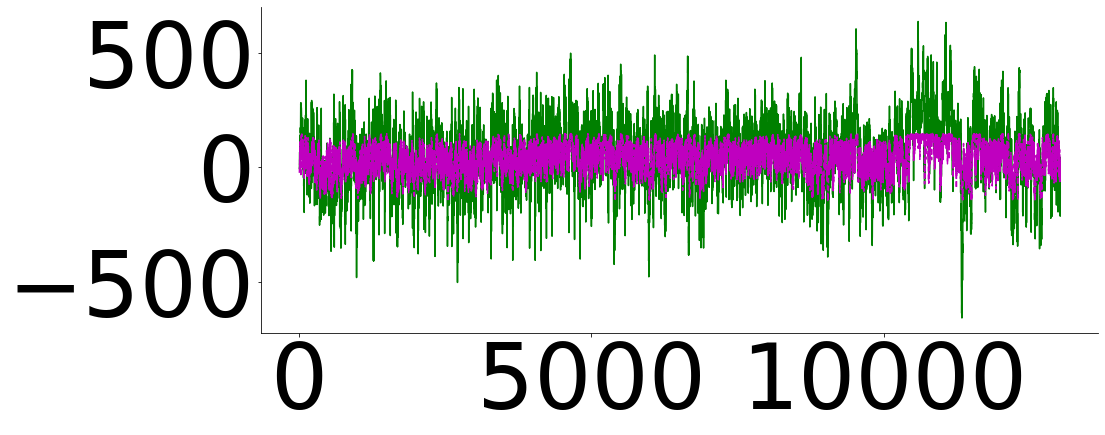

In [678]:
#fig, ax = plt.subplots(1, 1, figsize=(30, 22))
trainPredict = model.predict(X_batches)
testPredict= model.predict(X_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

#trainScore = model.evaluate(trainX, trainY, verbose=0)
#print(trainScore)

index = df.index.values
plt.figure(figsize=(15,6))
plt.plot(np.arange(step_futuro,size_train),nord_volumes[step_futuro:size_train],'g')
plt.plot(np.arange(step_futuro,size_train),np.ravel(trainPredict),'m--')

plt.plot(np.arange(size_train,size_train+size_test-step_futuro),nord_volumes[size_train:size_train-step_futuro+size_test],'g')
plt.plot(np.arange(size_train,size_train+size_test-step_futuro),np.ravel(testPredict),'m--')
#plt.axvline(df.index[size_train], c="c")
plt.show()

In [679]:
print(f"correlation coefficient:\n\n {np.corrcoef([np.ravel(y_test),np.ravel(testPredict)])}")

correlation coefficient:

 [[1.         0.62782719]
 [0.62782719 1.        ]]


## Creating graph $\rho(T_P)$ 

In [681]:
#rho_RNN_old_hidden250_step = np.zeros(20)
cont=0
N=500
N_space=500
m_bool=0
for Tp in range(1,21):
    
    #hyperparameters
    n_windows = 100   
    n_input =  1
    n_output = 1
    size_train = 10000+Tp
    size_test=3000+Tp
    print(f'size_train {size_train}')
    
    #dataset
    train_set = nord_volumes[:size_train]
    test_set = nord_volumes[size_train:size_test+size_train]
    
    X_batches, y_batches = create_batches(df = train_set,
                                      S = n_windows,
                                      input = n_input,
                                      output = n_output,
                                      Tp=Tp,
                                      size=size_train)
    
    X_test, y_test = create_batches(df = test_set,
                                      S = n_windows,
                                      input = n_input,
                                      output = n_output,
                                      Tp=Tp,
                                      size=size_test  
                                     )
    model = rnn_old(S = n_windows)
    #model.summary()
    #model = my_lstm(S = n_windows)
    #model = lstm_2layers(S = n_windows)


    # Fit the model using the training data genenerated above using 150 training iterations and a 5%
    # validation split.  Setting verbose to True prints information about each training iteration.
    hist = model.fit(X_batches, y_batches, batch_size=None, epochs=80, 
                 verbose=False,
                 validation_split=0.05)
    
    y_pred= model.predict(X_test)
    #predicted=np.concatenate((trainPredict,testPredict),axis=0)



                                      
   
    #correlation coefficient
    rho_Matrix=np.corrcoef([np.ravel(y_test),np.ravel(y_pred)])
    #rho_RNN_old_hidden250_step[cont]=rho_Matrix[0][1]
    print(f'step_futuro {Tp}')
    print(rho_Matrix[0][1])
    cont=cont+1

    



size_train 10001
x_data 10000
y_data 10000
x_data 3000
y_data 3000
step_futuro 1
0.8423399917667975
size_train 10002
x_data 10000
y_data 10000
x_data 3000
y_data 3000


KeyboardInterrupt: 

## The result of my thesis

(0.0, 1.0)

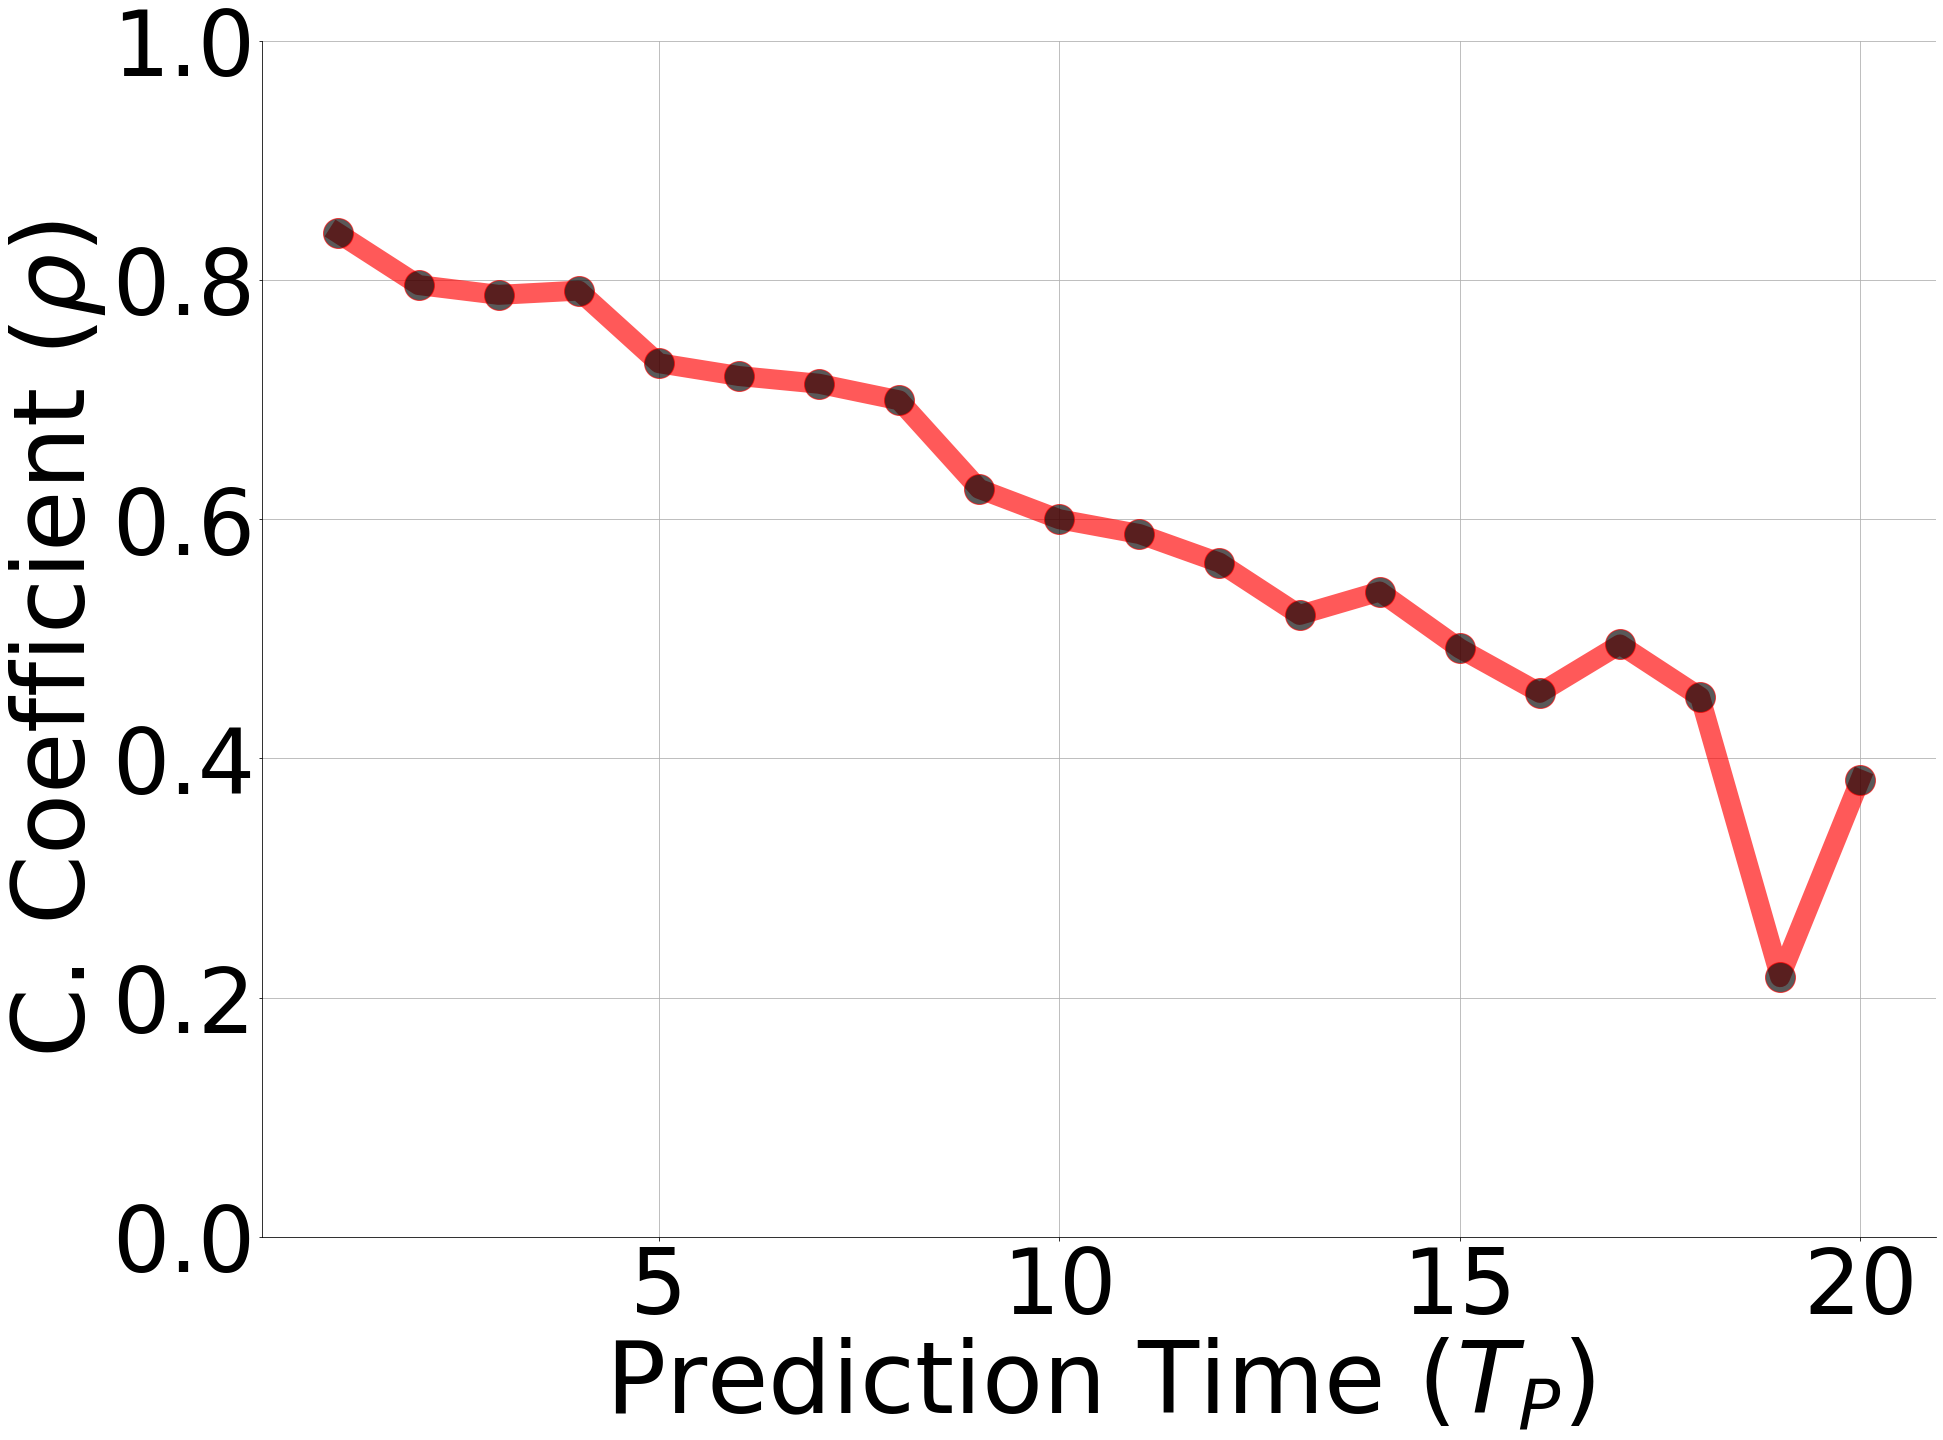

In [570]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))

    
step_vect = np.arange(1,21)

ax.plot(step_vect[0:20], 
        rho_RNN_old_step[0:20],
        color="red",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic old RNN',
        
       )




plt.grid(True)
# add labels for axes
ax.set_xlabel("Prediction Time ("+r"$T_P$"+")")
plt.ylabel('C. Coefficient ('+'$\\rho$'+')')

# add legend
#leg = ax.legend(loc="lower left",frameon=True,prop={'size': 70})
#leg.get_frame().set_edgecolor('black')
#leg.get_frame().set_linewidth(3)

#ax.set_title(f'North Italy');
plt.ylim(bottom=0,top=1)

### Comparison of the accuracy of models created by different RNNs using data fromat $D_1$

(0.0, 1.0)

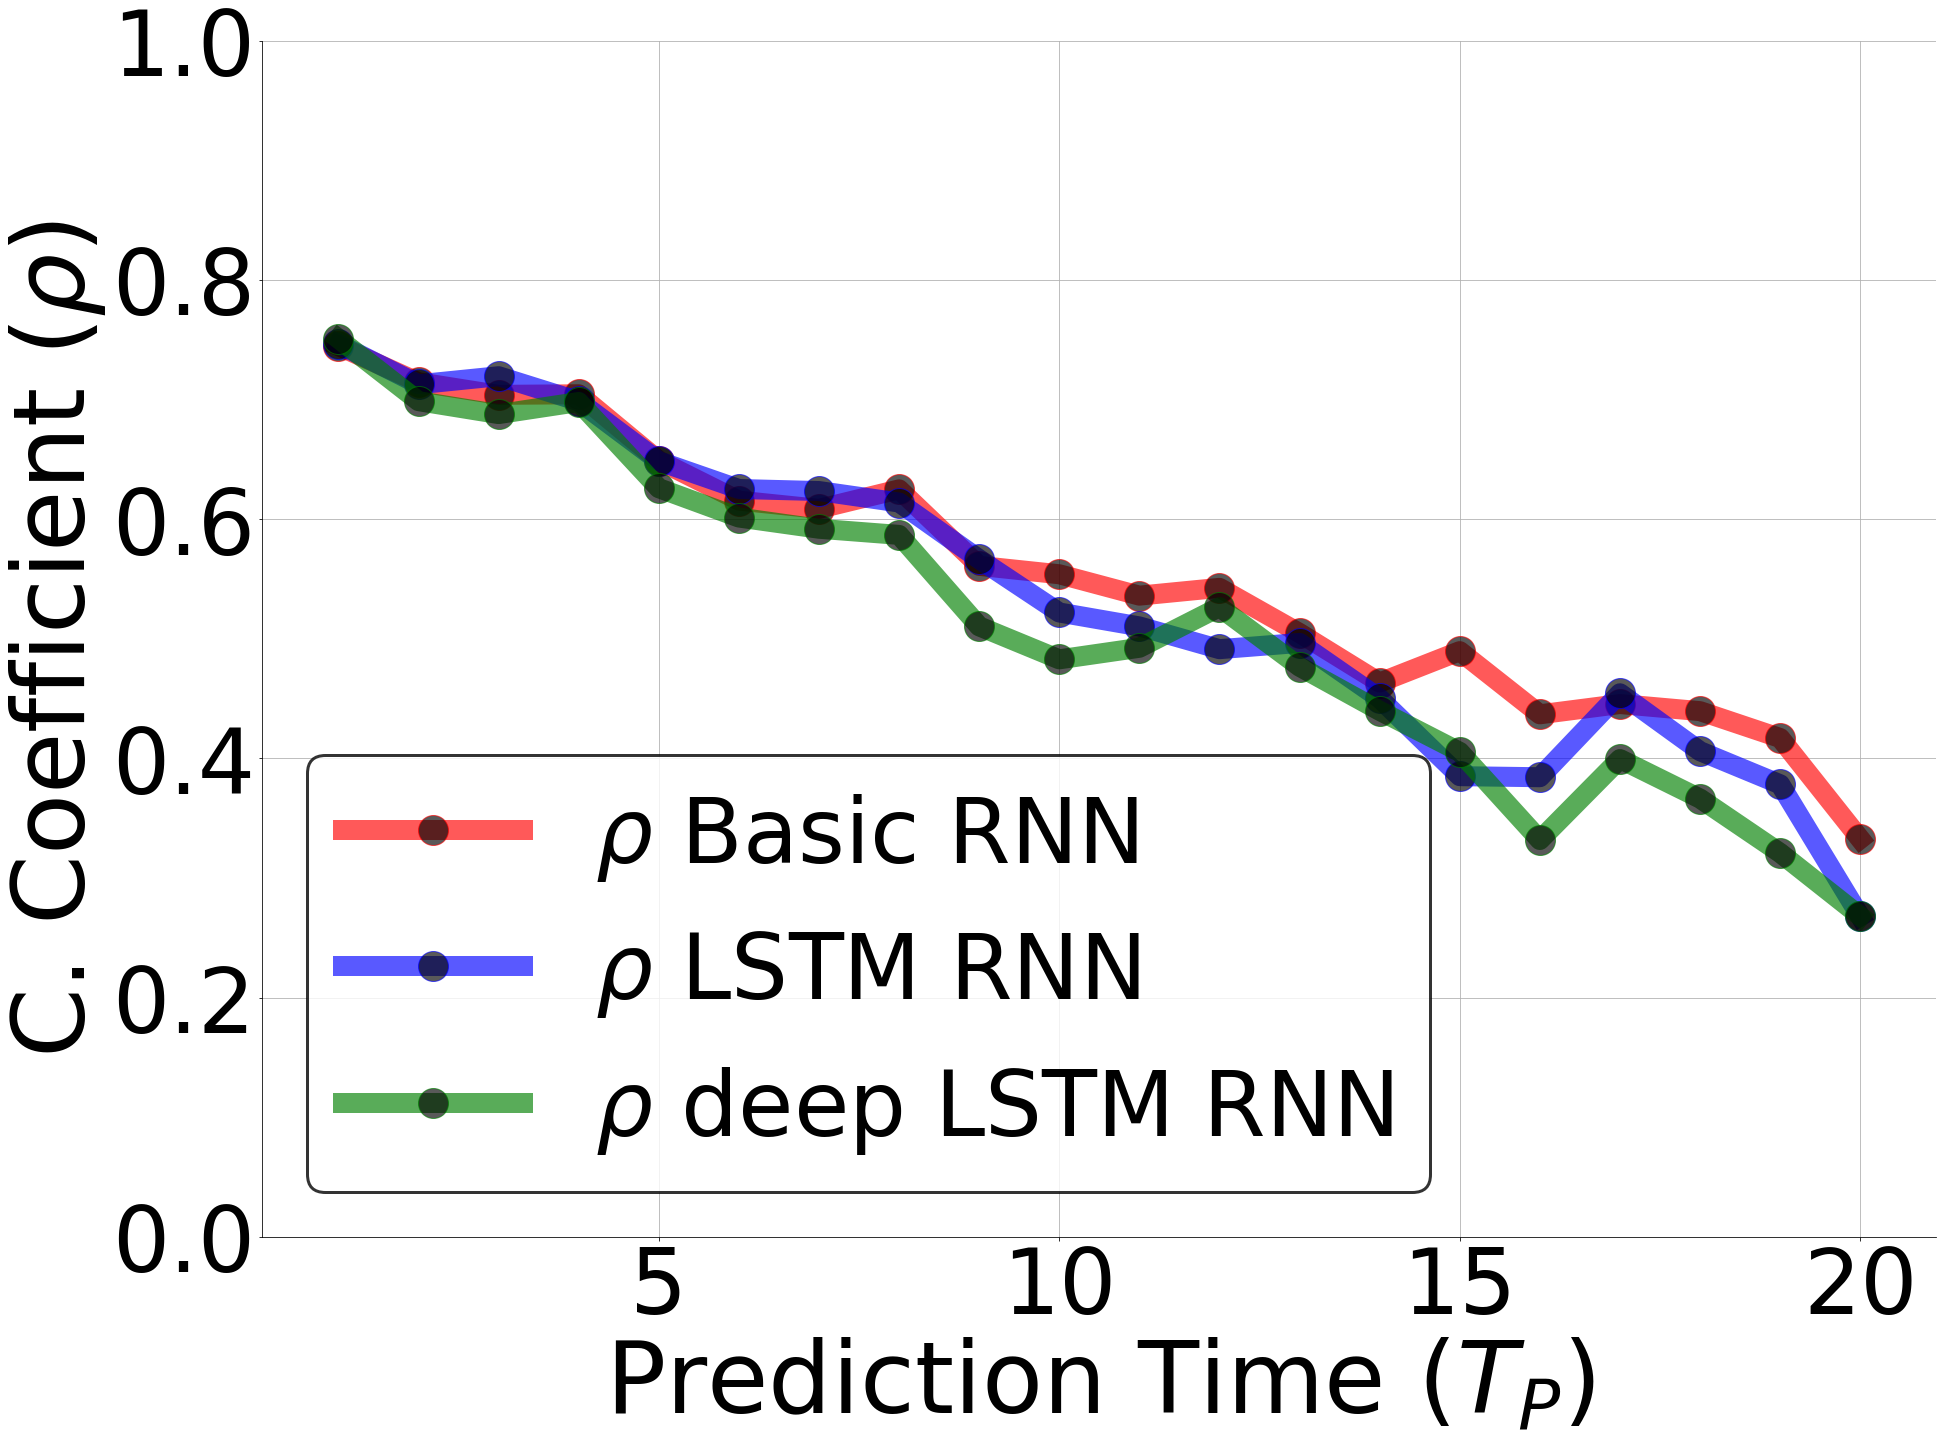

In [588]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))

    
step_vect = np.arange(1,21)

ax.plot(step_vect[0:20], 
        rho_RNN_old_hidden250_step[0:20],
        color="red",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic RNN',
        
       )

ax.plot(step_vect[0:20], 
        rho_RNN_LSTM_old_step[0:20],
        color="blue",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ LSTM RNN',  
       )

ax.plot(step_vect[0:20], 
        rho_RNN_LSTM_2layers_old_step[0:20],
        color="g",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ deep LSTM RNN',  
       )


plt.grid(True)
# add labels for axes
ax.set_xlabel("Prediction Time ("+r"$T_P$"+")")
plt.ylabel('C. Coefficient ('+'$\\rho$'+')')

# add legend
leg = ax.legend(loc="lower left",frameon=True,prop={'size': 90})
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(3)

#ax.set_title(f'North Italy');
plt.ylim(bottom=0,top=1)

## Is the LSTM model overfitting?
I changed the model's initialization function to permit a dynamical change of the hidden size of the network.

In [686]:
def my_lstm_dynamic_hidden_size(S, hidden_neurons, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    length_of_sequences=S
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    
    #hidden_neurons = 1000
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    
    #dens1 = Dense(hidden_neurons,name="dens1")(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

In the following loop "for" I will calculate the correlation coefficient as function of the model complexity using $T_p=4$.

In [ ]:

rho_RNN_LSTM_parameters = np.zeros(10)

cont=0

N = 1000     
X_tot=np.arange(0,N)
y_tot=nord_volumes[:N]
Tp=4
hidden_sizes=[10,30,50,70,100,150]
for hidden_size in hidden_sizes:
    
    
    # Check to make sure the data set is complete
    assert len(X_tot) == len(y_tot)

    # This is the number of points that will be used in as the training data
    dim=700

    # Separate the training data from the whole data set
    X_train = X_tot[:dim]
    y_train = y_tot[:dim]


    # Generate the training data for the RNN, using a sequence of 2
    rnn_input, rnn_training = format_data(y_train, Tp)


    # Create a recurrent neural network in Keras and produce a summary of the 
    # machine learning model
    # Change the method name to reflect which network you want to use 
    #model = lstm_2layers(S = Tp)
    #model = rnn(S = Tp)
    model = my_lstm_dynamic_hidden_size(S = Tp, hidden_neurons=hidden_size)
    #model.summary()
    
    
    # Fit the model using the training data genenerated above using 150 training iterations and a 5%
    # validation split.  Setting verbose to True prints information about each training iteration.
    hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=80, 
                 verbose=False,
                 validation_split=0.05)
    
    
    
    test = y_tot[dim:]
    testX,testY= format_data(test,Tp)
    testPredict= model.predict(testX)
                                      
   
    #correlation coefficient
    rho_Matrix=np.corrcoef([y_tot[dim+Tp:],np.ravel(testPredict)])
    rho_RNN_LSTM_parameters[cont]=rho_Matrix[0][1]
    print(f'hidden size {hidden_size}')
    print(rho_Matrix[0][1])
    cont=cont+1

    




(0.0, 1.0)

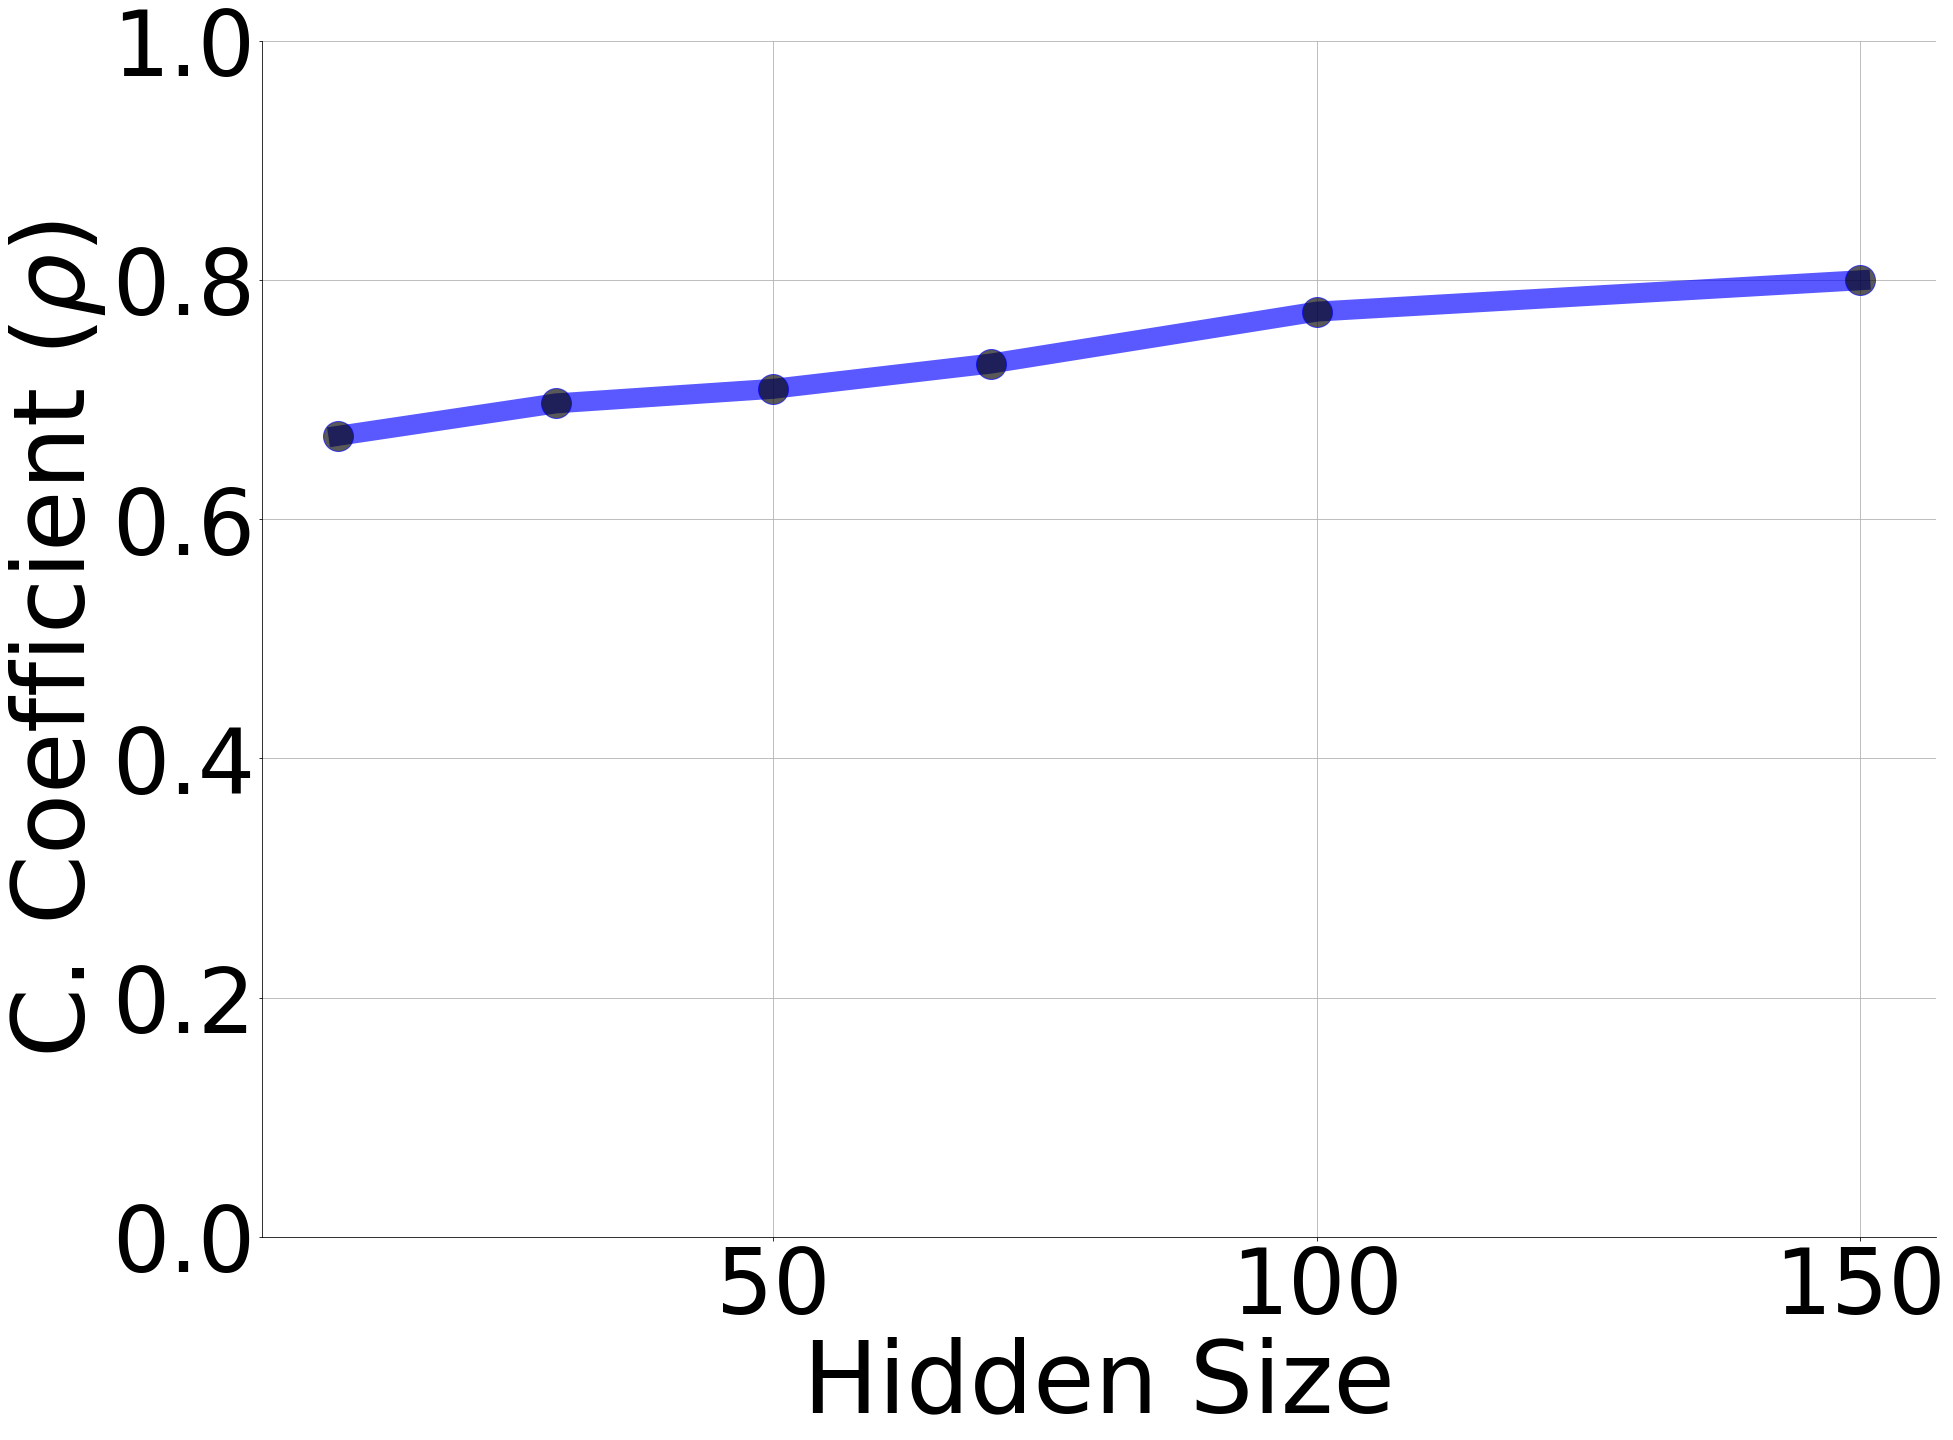

In [695]:
fig, ax = plt.subplots(1, 1, figsize=(30, 22))

    
hidden_sizes=[10,30,50,70,100,150]
ax.plot(hidden_sizes, 
        rho_RNN_LSTM_parameters[:6],
        color="b",
        lw=20,
        marker='o',
        markersize=30,
        markerfacecolor="black",
        alpha=0.65,
        label='$\\rho$ Basic RNN',
        
       )

plt.grid(True)
# add labels for axes
ax.set_xlabel("Hidden Size")
plt.ylabel('C. Coefficient ('+'$\\rho$'+')')

#ax.set_title(f'North Italy');
plt.ylim(bottom=0,top=1)